# Fake and real Facial Recognition and Verification



In [1]:
!pip install mtcnn

In [126]:
pip install seaborn

     -------------------------------------- 292.8/292.8 KB 6.0 MB/s eta 0:00:00



In [2]:
pip install keras --user

Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import pandas as pd
from keras.applications.mobilenet import MobileNet, preprocess_input
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Dense,BatchNormalization, Flatten, MaxPool2D
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, Callback
from keras.layers import Conv2D, Reshape
#from keras.utils import Sequence
from keras.backend import epsilon
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
#from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
import cv2
from tqdm.notebook import tqdm_notebook as tqdm

In [1]:
import os

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    print("Name:", gpu.name, "  Type:", gpu.device_type)

Name: /physical_device:GPU:0   Type: GPU


In [4]:
from tensorflow.python.client import device_lib

device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 13407463120251310783
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 11302404096
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 10928656448682944090
 physical_device_desc: "device: 0, name: NVIDIA GeForce GTX TITAN X, pci bus id: 0000:01:00.0, compute capability: 5.2"
 xla_global_id: 416903419]

In [5]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [6]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping()

## Section 2 - data improt


In [7]:
folder = 'final project/data/data/CelebA_StyleGan'
#train_folder = 'final project/data/data/CelebA_StyleGan/real'
#detect_folder= folder +'/detect'
test_folder='final project/data/data/CelebA_StyleGan_testset'

Data prepare 



##  Declare a List of Functions 




In [8]:
#@title
import numpy as np
import cv2
from IPython.display import Image, display
#import cv2_imshow
from mtcnn import MTCNN

import tensorflow 
from tensorflow import keras


# Loads an image from a file using OpenCV.
# NOTE: OpenCV loads an image in BGR format by default,
#       so we must convert it back to the RGB format.
#
def load_image(filename):
    img = cv2.imread(filename)
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)


# Draw a bounding box over the image with a 
# text.
#
def draw_box(img, x1, y1, x2, y2, text): 
    img = cv2.rectangle(img,(x1,y1),(x2,y2),(255,255,0),2)

    if text != "":
        img = cv2.rectangle(img,(x1,y1),(x2,y1 + 12),(255,255,0),-1)
        img = cv2.putText(img, text, (x1, y1 + 10), cv2.FONT_HERSHEY_PLAIN, 0.7, (0,0,0), 1, cv2.LINE_AA)

    return img


# Crops out parts of an image based on a list of bounding
# boxes. The cropped faces are also resized to 160x160 in
# preparation for passing it to FaceNet to compute the
# face embeddings.
#
def crop_faces_to_160x160(img, bounding_boxes): 
    cropped_faces = []

    for (x,y,w,h) in bounding_boxes:
        cropped_face = img[y:y+h, x:x+w]
        cropped_face = cv2.resize(cropped_face, (160, 160), interpolation=cv2.INTER_CUBIC)
        cropped_faces.append(cropped_face)
    
    return np.array(cropped_faces)


# Shows an image in Colab
#
def show_image(img):
    cv2.imshow(cv2.cvtColor(img, cv2.COLOR_RGB2BGR))



from IPython.display import display, Javascript
from js2py import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename


def launch_camera(prompt, filename):

    print (prompt)
    try:
      filename1 = take_photo(filename)
      print('Saved to ' + filename1)
      
      # Show the image which was just taken.
      #show_image(filename1)

    except Exception as err:
      # Errors will be thrown if the user does not have a webcam or if they do not
      # grant the page permission to access it.
      print(str(err))


###RESNet-50

In [9]:
import keras
from tensorflow.keras import datasets,models,layers

In [10]:
 #Complete your code here 

# specify the desired input size to the convolutional neural network
image_size = (128, 128)

# specify the training batch size
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    folder,
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    folder,
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 45023 files belonging to 2 classes.
Using 36019 files for training.
Found 45023 files belonging to 2 classes.
Using 9004 files for validation.


In [21]:
def create_tb_callback(): 

    root_logdir = os.path.join(os.curdir, "tb_logs")

    def get_run_logdir():    # use a new directory for each run
        import time
        run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
        return os.path.join(root_logdir, run_id)

    run_logdir = get_run_logdir()

    tb_callback = tf.keras.callbacks.TensorBoard(run_logdir)

    return tb_callback

model_checkpoint_callback =[ keras.callbacks.ModelCheckpoint(
    filepath="best_checkpoint",
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True),
     keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
]

In [15]:
#ResNet 50 frezze all
resnet_model = Sequential()

pretrained_model= tf.keras.applications.ResNet50(include_top=False,
                   input_shape=(128,128,3),
                   pooling='avg',classes=2,
                   weights='imagenet')
for layer in pretrained_model.layers:
        layer.trainable=False


resnet_model.add(pretrained_model)


resnet_model.add(Flatten())
resnet_model.add(Dense(512, activation='relu'))
#resnet_model.add(Dense(512, activation='relu'))
resnet_model.add(keras.layers.Dropout(0.5))
resnet_model.add(Dense(1, activation='sigmoid'))
resnet_model.summary()

resnet_model.compile(optimizer=Adam(learning_rate=0.001),loss='binary_crossentropy',metrics=['accuracy'])
history = resnet_model.fit(train_ds, validation_data=val_ds, epochs=30,callbacks=[create_tb_callback(), model_checkpoint_callback])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten_1 (Flatten)         (None, 2048)              0         
                                                                 
 dense_2 (Dense)             (None, 512)               1049088   
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_3 (Dense)             (None, 1)                 513       
                                                                 
Total params: 24,637,313
Trainable params: 1,049,601
Non-trainable params: 23,587,712
_________________________________________________________________
Epoch 1/30
1126/1126 [============

In [16]:
resnet_model.save('50mymodel_b32.pb')
resnet_model.save('50mymodel_b32.savedmodel')
resnet_model.save('50mymodel_b32.h5')

INFO:tensorflow:Assets written to: 50mymodel_b32.pb\assets
INFO:tensorflow:Assets written to: 50mymodel_b32.savedmodel\assets


In [171]:
#normal 
resnet_model = Sequential()

pretrained_model= tf.keras.applications.ResNet50(include_top=False,
                   input_shape=(128,128,3),
                   pooling='avg',classes=2,
                   weights='imagenet')
for layer in pretrained_model.layers:
        layer.trainable=False


resnet_model.add(pretrained_model)


resnet_model.add(Flatten())
resnet_model.add(Dense(512, activation='relu'))
#resnet_model.add(Dense(512, activation='relu'))
resnet_model.add(keras.layers.Dropout(0.5))
resnet_model.add(Dense(1, activation='sigmoid'))
resnet_model.summary()

resnet_model.compile(optimizer=Adam(learning_rate=0.001),loss='binary_crossentropy',metrics=['accuracy'])
history = resnet_model.fit(train_ds, validation_data=val_ds, epochs=30,callbacks=[create_tb_callback(), model_checkpoint_callback])

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten_7 (Flatten)         (None, 2048)              0         
                                                                 
 dense_16 (Dense)            (None, 512)               1049088   
                                                                 
 dropout_8 (Dropout)         (None, 512)               0         
                                                                 
 dense_17 (Dense)            (None, 1)                 513       
                                                                 
Total params: 24,637,313
Trainable params: 1,049,601
Non-trainable params: 23,587,712
_________________________________________________________________


In [17]:
#no average polling

resnet_model = Sequential()

pretrained_model= tf.keras.applications.ResNet50(include_top=False,
                   input_shape=(128,128,3),
                   classes=2,
                   weights='imagenet')
for layer in pretrained_model.layers:
        layer.trainable=False


resnet_model.add(pretrained_model)


resnet_model.add(Flatten())
resnet_model.add(Dense(512, activation='relu'))
#resnet_model.add(Dense(512, activation='relu'))
resnet_model.add(keras.layers.Dropout(0.5))
resnet_model.add(Dense(1, activation='sigmoid'))
resnet_model.summary()
resnet_model.compile(optimizer=Adam(learning_rate=0.001),loss='binary_crossentropy',metrics=['accuracy'])
history = resnet_model.fit(train_ds, validation_data=val_ds, epochs=30,callbacks=[create_tb_callback(), model_checkpoint_callback])

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 4, 4, 2048)        23587712  
                                                                 
 flatten_2 (Flatten)         (None, 32768)             0         
                                                                 
 dense_4 (Dense)             (None, 512)               16777728  
                                                                 
 dropout_2 (Dropout)         (None, 512)               0         
                                                                 
 dense_5 (Dense)             (None, 1)                 513       
                                                                 
Total params: 40,365,953
Trainable params: 16,778,241
Non-trainable params: 23,587,712
_________________________________________________________________
Epoch 1/30
1126/1126 [===========

In [18]:
resnet_model.save('50_nopoolingmymodel_b32.pb')
resnet_model.save('50nopoolingmymodel_b32.savedmodel')
resnet_model.save('5nopooling0mymodel_b32.h5')

INFO:tensorflow:Assets written to: 50_nopoolingmymodel_b32.pb\assets
INFO:tensorflow:Assets written to: 50nopoolingmymodel_b32.savedmodel\assets


In [22]:
#unfrezze_1
resnet_model = Sequential()
pretrained_model= tf.keras.applications.ResNet50(include_top=False,
                   input_shape=(128,128,3),
                   pooling='avg',classes=2,
                   weights='imagenet')
for layer in pretrained_model.layers[:10]:
   layer.trainable = False
for layer in pretrained_model.layers[10:]:
   layer.trainable = True

resnet_model.add(pretrained_model)


resnet_model.add(Flatten())
resnet_model.add(Dense(512, activation='relu'))
#resnet_model.add(Dense(512, activation='relu'))
resnet_model.add(keras.layers.Dropout(0.5))
resnet_model.add(Dense(1, activation='sigmoid'))
resnet_model.summary()

resnet_model.compile(optimizer=Adam(learning_rate=0.001),loss='binary_crossentropy',metrics=['accuracy'])
history = resnet_model.fit(train_ds, validation_data=val_ds, epochs=30,callbacks=[create_tb_callback(), model_checkpoint_callback])

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten_4 (Flatten)         (None, 2048)              0         
                                                                 
 dense_8 (Dense)             (None, 512)               1049088   
                                                                 
 dropout_4 (Dropout)         (None, 512)               0         
                                                                 
 dense_9 (Dense)             (None, 1)                 513       
                                                                 
Total params: 24,637,313
Trainable params: 24,570,305
Non-trainable params: 67,008
_________________________________________________________________
Epoch 1/30
1126/1126 [===============

In [23]:
resnet_model.save('50_10_b32.pb')
resnet_model.save('50_10_b32.savedmodel')
resnet_model.save('50_10_b32.h5')

INFO:tensorflow:Assets written to: 50_10_b32.pb\assets
INFO:tensorflow:Assets written to: 50_10_b32.savedmodel\assets


In [24]:
# test different pretrained 152
resnet_model = Sequential()

pretrained_model= tf.keras.applications.ResNet152(include_top=False,
                   input_shape=(128,128,3),
                   pooling='avg',classes=2,
                   weights='imagenet')
for layer in pretrained_model.layers:
        layer.trainable=False


resnet_model.add(pretrained_model)



resnet_model.add(Flatten())
resnet_model.add(Dense(512, activation='relu'))
#resnet_model.add(Dense(512, activation='relu'))
resnet_model.add(keras.layers.Dropout(0.5))
resnet_model.add(Dense(1, activation='sigmoid'))
resnet_model.summary()
resnet_model.compile(optimizer=Adam(learning_rate=0.001),loss='binary_crossentropy',metrics=['accuracy'])
history = resnet_model.fit(train_ds, validation_data=val_ds, epochs=30,callbacks=[create_tb_callback(), model_checkpoint_callback])

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet152 (Functional)      (None, 2048)              58370944  
                                                                 
 flatten_5 (Flatten)         (None, 2048)              0         
                                                                 
 dense_10 (Dense)            (None, 512)               1049088   
                                                                 
 dropout_5 (Dropout)         (None, 512)               0         
                                                                 
 dense_11 (Dense)            (None, 1)                 513       
                                                                 
Total params: 59,420,545
Trainable params: 1,049,601
Non-trainable params: 58,370,944
_________________________________________________________________
Epoch 1/30
1126/1126 [============

In [25]:
resnet_model.save('152_b32.pb')
resnet_model.save('152_b32.savedmodel')
resnet_model.save('152_b32.h5')

INFO:tensorflow:Assets written to: 152_b32.pb\assets
INFO:tensorflow:Assets written to: 152_b32.savedmodel\assets


In [26]:
# test different pretrained 101
resnet_model = Sequential()

pretrained_model= tf.keras.applications.ResNet101(include_top=False,
                   input_shape=(128,128,3),
                   pooling='avg',classes=2,
                   weights='imagenet')
for layer in pretrained_model.layers:
        layer.trainable=False


resnet_model.add(pretrained_model)



resnet_model.add(Flatten())
resnet_model.add(Dense(512, activation='relu'))
#resnet_model.add(Dense(512, activation='relu'))
resnet_model.add(keras.layers.Dropout(0.5))
resnet_model.add(Dense(1, activation='sigmoid'))
resnet_model.summary()
resnet_model.compile(optimizer=Adam(learning_rate=0.001),loss='binary_crossentropy',metrics=['accuracy'])
history = resnet_model.fit(train_ds, validation_data=val_ds, epochs=30,callbacks=[create_tb_callback(), model_checkpoint_callback])

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet101 (Functional)      (None, 2048)              42658176  
                                                                 
 flatten_6 (Flatten)         (None, 2048)              0         
                                                                 
 dense_12 (Dense)            (None, 512)               1049088   
                                                                 
 dropout_6 (Dropout)         (None, 512)               0         
                                                                 
 dense_13 (Dense)            (None, 1)                 513       
                                                                 
Total params: 43,707,777
Trainable params: 1,049,601
Non-trainable params: 42,658,176
_________________________________________________________________
Epoch 1/30
1126/1126 [============

In [27]:
resnet_model.save('101_b32.pb')
resnet_model.save('101_b32.savedmodel')
resnet_model.save('101_b32.h5')

INFO:tensorflow:Assets written to: 101_b32.pb\assets
INFO:tensorflow:Assets written to: 101_b32.savedmodel\assets


In [28]:
#unfrezze_2
resnet_model = Sequential()

pretrained_model= tf.keras.applications.ResNet50(include_top=False,
                   input_shape=(128,128,3),
                   pooling='avg',classes=2,
                   weights='imagenet')
for layer in pretrained_model.layers[:5]:
   layer.trainable = False
for layer in pretrained_model.layers[5:]:
   layer.trainable = True


resnet_model.add(pretrained_model)


resnet_model.add(Flatten())
resnet_model.add(Dense(512, activation='relu'))
#resnet_model.add(Dense(512, activation='relu'))
resnet_model.add(keras.layers.Dropout(0.5))
resnet_model.add(Dense(1, activation='sigmoid'))
resnet_model.summary()
resnet_model.compile(optimizer=Adam(learning_rate=0.001),loss='binary_crossentropy',metrics=['accuracy'])
history = resnet_model.fit(train_ds, validation_data=val_ds, epochs=30,callbacks=[create_tb_callback(), model_checkpoint_callback])

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten_7 (Flatten)         (None, 2048)              0         
                                                                 
 dense_14 (Dense)            (None, 512)               1049088   
                                                                 
 dropout_7 (Dropout)         (None, 512)               0         
                                                                 
 dense_15 (Dense)            (None, 1)                 513       
                                                                 
Total params: 24,637,313
Trainable params: 24,574,593
Non-trainable params: 62,720
_________________________________________________________________
Epoch 1/30
1126/1126 [===============

In [29]:
resnet_model.save('50_5_b32.pb')
resnet_model.save('50_5_b32.savedmodel')
resnet_model.save('50_5_b32.h5')

INFO:tensorflow:Assets written to: 50_5_b32.pb\assets
INFO:tensorflow:Assets written to: 50_5_b32.savedmodel\assets


In [47]:
def create_tb_callback(): 

    root_logdir = os.path.join(os.curdir, "tb_logs")

    def get_run_logdir():    # use a new directory for each run
	    import time
	    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
	    return os.path.join(root_logdir, run_id)

    run_logdir = get_run_logdir()

    tb_callback = tf.keras.callbacks.TensorBoard(run_logdir)

    return tb_callback

model_checkpoint_callback =[ keras.callbacks.ModelCheckpoint(
    filepath="best_checkpoint",
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True),
     keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
]

In [173]:
resnet_model.compile(optimizer=Adam(learning_rate=0.001),loss='binary_crossentropy',metrics=['accuracy'])

history = resnet_model.fit(train_ds, validation_data=val_ds, epochs=30,callbacks=[create_tb_callback(), model_checkpoint_callback])

Epoch 1/30
63/63 [==============================] - 32s 385ms/step - loss: 0.8923 - accuracy: 0.7090 - val_loss: 0.6878 - val_accuracy: 0.6898
Epoch 2/30
63/63 [==============================] - 21s 327ms/step - loss: 0.4156 - accuracy: 0.8035 - val_loss: 0.7032 - val_accuracy: 0.6944
Epoch 3/30
63/63 [==============================] - 19s 299ms/step - loss: 0.3683 - accuracy: 0.8300 - val_loss: 0.7883 - val_accuracy: 0.6926
Epoch 4/30
63/63 [==============================] - 19s 301ms/step - loss: 0.3348 - accuracy: 0.8535 - val_loss: 0.7637 - val_accuracy: 0.6906
Epoch 5/30
63/63 [==============================] - 21s 327ms/step - loss: 0.2992 - accuracy: 0.8700 - val_loss: 0.7114 - val_accuracy: 0.7114
Epoch 6/30
63/63 [==============================] - 19s 302ms/step - loss: 0.2997 - accuracy: 0.8645 - val_loss: 0.9630 - val_accuracy: 0.6949


In [51]:
resnet_model.load_weights('best_checkpoint')
resnet_model.evaluate(val_ds)

282/282 [==============================] - 16s 56ms/step - loss: 0.1094 - accuracy: 0.9715


[0.10944093018770218, 0.9714571237564087]

In [174]:
resnet_model.save('50-fmymodel_b32.savedmodel')

INFO:tensorflow:Assets written to: 50-fmymodel_b32.savedmodel\assets


In [175]:
resnet_model.save('50-fmymodel_b32.h5')

In [54]:
resnet_model.save('50-5mymodel_b32.pb')

INFO:tensorflow:Assets written to: 50-5mymodel_b32.pb\assets


In [30]:
%load_ext tensorboard
%tensorboard --logdir tb_logs --host localhost --port 8084

In [256]:
test_ds = keras.preprocessing.image_dataset_from_directory(
    test_folder,
    labels='inferred',
    label_mode='categorical',
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 2000 files belonging to 2 classes.


In [225]:
testr_folder='final project/data/real_and_fake_face_detection/real_and_fake_face'

In [245]:
testr_ds = keras.preprocessing.image_dataset_from_directory(
    testr_folder,
    labels='inferred',
    label_mode='categorical',
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 2041 files belonging to 2 classes.


In [1]:
import ipywidgets as widgets

uploader = widgets.FileUpload(
    accept='image/*',  # Accepted file extension e.g. '.txt', '.pdf', 'image/*', 'image/*,.pdf'
    multiple=True  # True to accept multiple files upload else False
)

display(uploader)

FileUpload(value={}, accept='image/*', description='Upload', multiple=True)

In [11]:
model = keras.models.load_model("50-5mymodel_b32.h5")

In [39]:
import keras
key = next(iter(uploader.value))
image_size=(128,128)
with open(key, "w+b") as file:
    file.write(uploader.data[0])

img = tf.keras.preprocessing.image.load_img(
    key, target_size=image_size
)

# we convert the image to numpy array
img_array = tf.keras.preprocessing.image.img_to_array(img)

# Although we only have single image, however our model expected data in batches
# so we will need to add in the batch axis too
img_array = tf.expand_dims(img_array, 0) # Create a batch

# we load the model saved earlier and do the inference 
#cv2.show(img)
predictions = model(img_array)
print(predictions)
if predictions[0] > 0.5: 
    print('It is a real face ')
else:
    print('It is a fake face')

tf.Tensor([[2.0057942e-17]], shape=(1, 1), dtype=float32)
It is a fake face


102981632/102967424 [==============================] - 3s 0us/step


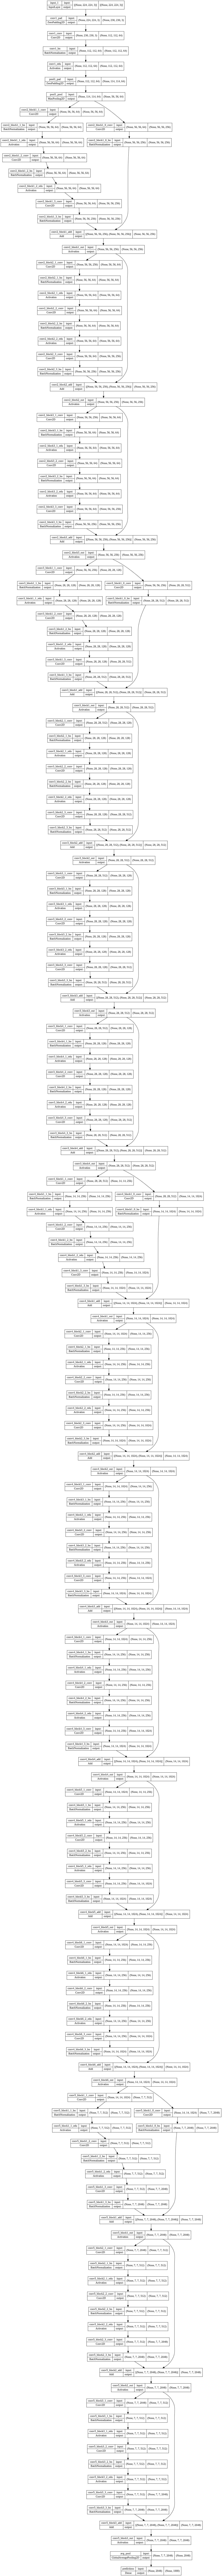

In [ ]:
#from tensorflow.keras.utils import plot_model
# It will download the weights that might take a while
# Also, the summary will be quite long, since Resnet50 is a much larger network than VGG16

from tensorflow.keras.applications import resnet50

resnet50_model = resnet50.ResNet50(weights='imagenet')

# let's plot the model, instead of using model.summary(), as it is easier to see some of the skip connections
tensorflow.keras.utils.plot_model(resnet50_model, to_file="resnet.png", show_shapes=True)